# Interactive Analysis Notebook

In [9]:
# Import packages and dependencies
import importlib
import time
import matplotlib
from matplotlib import pyplot as plt
import os
from pathlib import Path
from pipeline import pipeline
from analysis import *
import figure
from subject_analysis import Dataset, Cohort, Subject
import compute_ld_centering

In [2]:
RESEARCH_DIR = Path("/Users/anantajit/Documents/UCSF")
COHORT = \
    "LD/FullDataset"
SOURCE_FILE = \
    "raw_dataset.mat"
DEMOGRAPHICS_FILE = \
    "demographics.csv"
SOURCE_STRUCT = \
    "LD_Patients"

INPUT_PATH = RESEARCH_DIR / "datasets" / COHORT
DEMOGRAPHICS_PATH = INPUT_PATH / DEMOGRAPHICS_FILE
OUTPUT_PATH = RESEARCH_DIR / "results" / COHORT
CACHE_PATH = RESEARCH_DIR / "results" / COHORT / "cache"

FORCE_ANALYSIS = False

DPI = 300
plot_settings = {
    "plot_order": ["Controls", "LD Patients"],
    "colormap": {
        "LOWER": "#1f77b4",
        "CENTRAL": "#ff7f0e",
        "UPPER": "#2ca02c"
    },

    "error-color": "black",
    "line-width": 1.5,
    "error-cap-size": 10,
    "error-line-style": '',
    "font_size": 14,
    "font_family": "Times New Roman",

    "motion_lw": 2.0,
    "motion_alpha": 0.75,

    "annotation_padding": 2
}

trimming_pipeline = [
        trim_by_subject_trial_count,  # remove subjects with <25 trials
        trim_by_group_initial_pitch_distribution,  # remove trials which have initial pitch deviation >2std from mean
        (trim_by_subject_name,
         dict(exclude=[("LD Patients", "20170516"), ("LD Patients", "20170307")])
         ),
        rename_subjects_by_group  # is this strictly necessary?
    ]

In [3]:
ld = Dataset(str(INPUT_PATH / SOURCE_FILE), SOURCE_STRUCT)
demographics = pd.read_csv(DEMOGRAPHICS_PATH)

if FORCE_ANALYSIS or not (Path(CACHE_PATH) / "centering_data.csv").is_file():
    compute_ld_centering.gen_centering_csv(dataset=ld, OUTPUT_PATH=OUTPUT_PATH, CACHE_PATH=CACHE_PATH)

if FORCE_ANALYSIS or not (Path(CACHE_PATH / "trimmed_dataset.csv").is_file()
                          and Path(CACHE_PATH / "peripheral_dataset.csv").is_file()):
    compute_ld_centering.gen_centering_analysis(demographics=demographics, CACHE_PATH=CACHE_PATH)

# TODO: move plotting code into more accessible cells here
# compute_ld_centering.gen_group_figures(dataset=ld, CACHE_PATH=CACHE_PATH, OUTPUT_PATH=OUTPUT_PATH, plot_settings=plot_settings, DPI=DPI)

# compute_ld_centering.gen_subject_figures(dataset=ld, CACHE_PATH=CACHE_PATH, OUTPUT_PATH=OUTPUT_PATH, plot_settings=plot_settings, DPI=DPI)

output_dataset = pd.read_csv(CACHE_PATH / "peripheral_dataset.csv")

plot_settings["colormap"] = {
    "Controls": {
        "UPPER": "#1f77b4",
        "CENTRAL": "#ff7f0e",
        "LOWER": "#2ca02c"
    },
    "LD Patients": {
        "UPPER": "#d62728",
        "CENTRAL": "#9467bd",
        "LOWER": "#8c564b"
    }
}


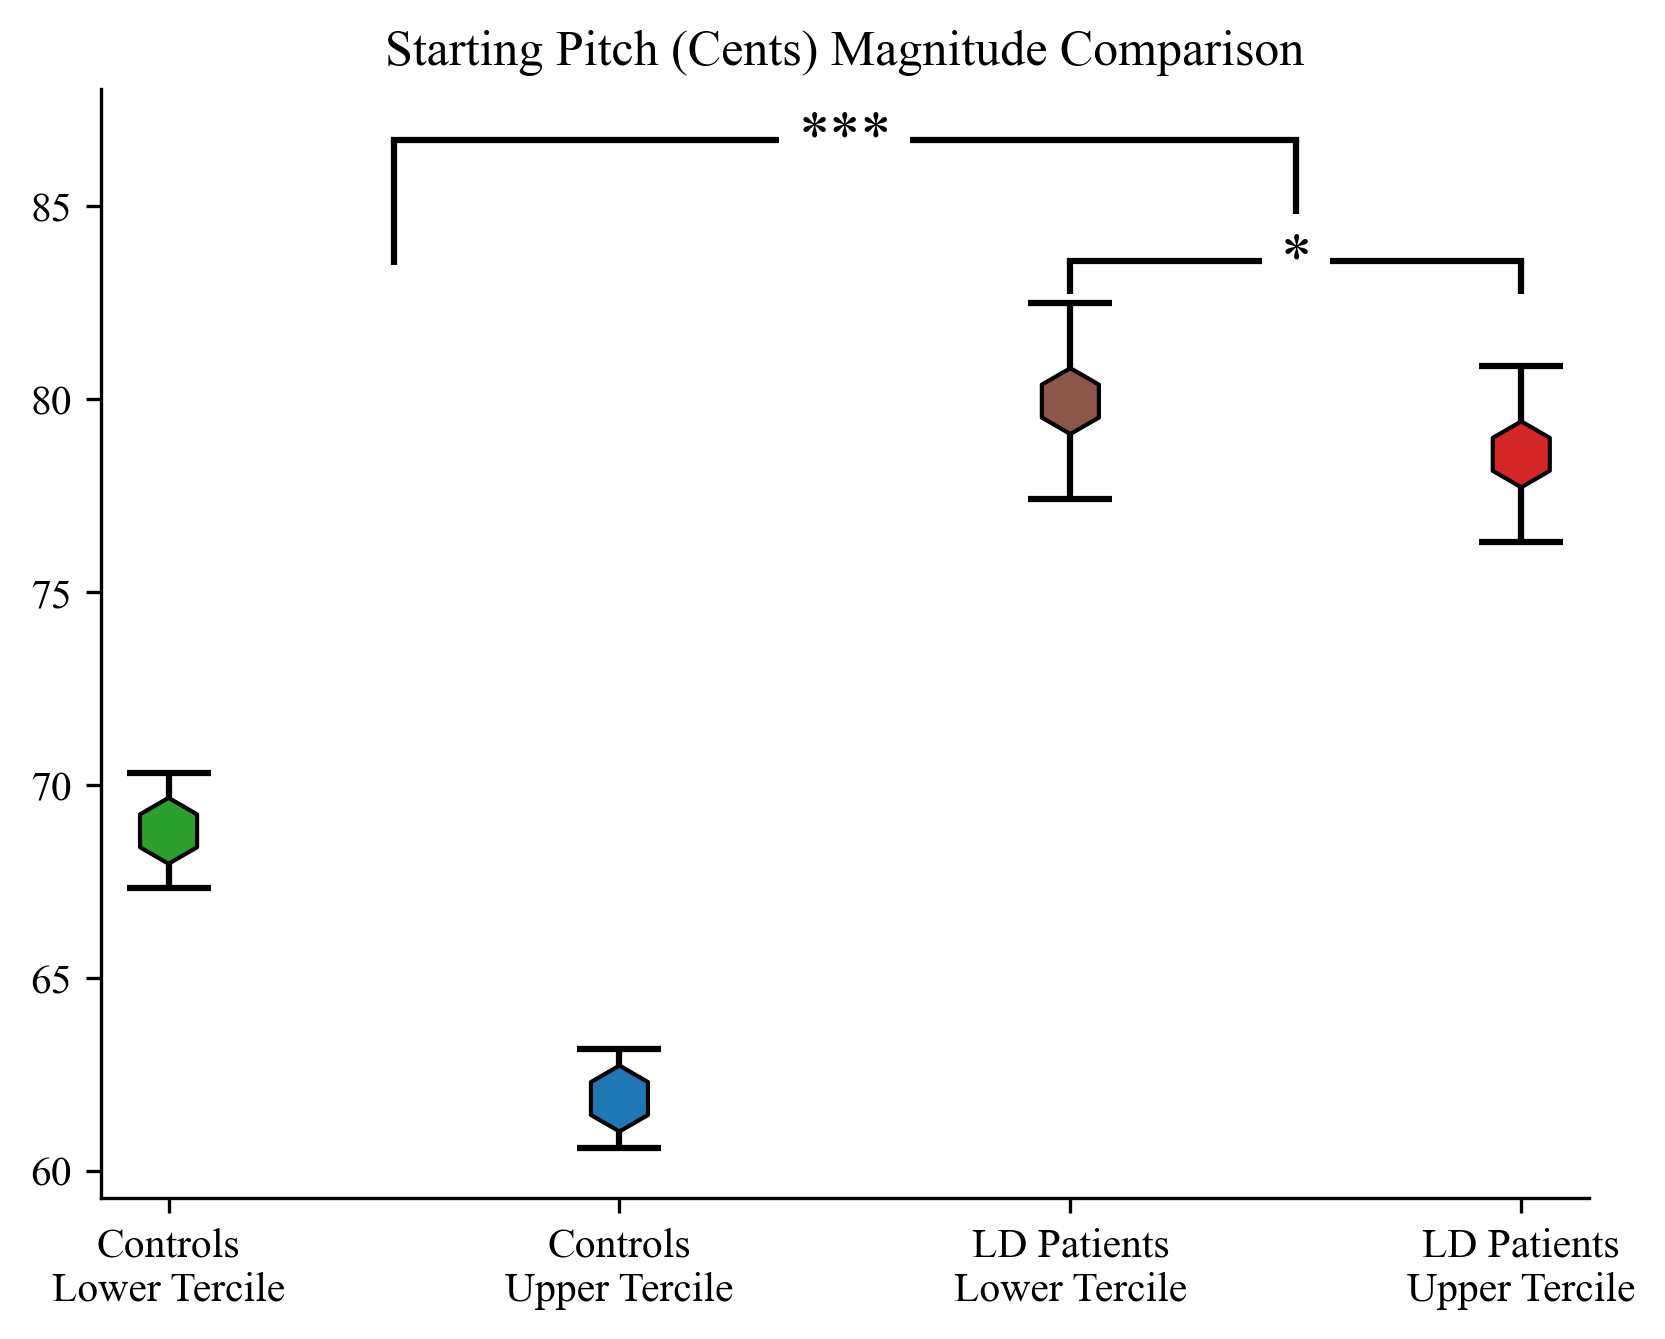

In [29]:
importlib.reload(figure)

# set the font to times new roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(1, 1, dpi=300)
figure.group_pitch_magnitude_comparison(output_dataset, fig, plot_settings, ("Controls", "LD Patients"), label_map={
    ("Controls", "UPPER"): "Controls\nUpper Tercile",
    ("Controls", "CENTRAL"): "Controls\nCentral Tercile",
    ("Controls", "LOWER"): "Controls\nLower Tercile",
    ("LD Patients", "UPPER"): "LD Patients\nUpper Tercile",
    ("LD Patients", "CENTRAL"): "LD Patients\nCentral Tercile",
    ("LD Patients", "LOWER"): "LD Patients\nLower Tercile"
})
figure.significance_bar(ax, 2, 3, max(ax.get_ylim()), display_string= "*")
# optional: adds a grouping bracket for controls (without significance)
# figure.significance_bar(ax, 0, 1, max(ax.get_ylim()), display_string= "")
figure.significance_bar(ax, 0.5, 2.5, max(ax.get_ylim()) + 2, display_string= "***", marker_size=30)
plt.show()
